%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt

import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot
from tools import NMD as nmd

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import kendalltau
import importlib

In [2]:
def plot_reconstruction(
    X_reconstruction, X, title, hue=None, type="scatter", sample_fraction=None
):
    """Plot original sparse non-negative matrix against the reconstructed one

    Also computes the Pearson correlation between both

    Args:
        X_reconstruction (_type_): Reconstructed matrix, e.g. np.maximum(0, Theta)
        X (_type_): The original sparse non-negative matrix
        title (_type_): _description_
        type (str, optional): _description_. Defaults to "scatter".
        sample_fraction (_type_, optional): _description_. Defaults to None.
    """
    X_recon_max = np.max(X_reconstruction)
    X_max = np.max(X)
    max_axis = max(X_recon_max, X_max)
    correlation = np.corrcoef(X_reconstruction.flatten(), X.flatten())[0][1]

    df = pd.DataFrame(
        {"original": X.flatten(), "reconstruction": X_reconstruction.flatten()}
    )

    if sample_fraction:
        df = df.sample(frac=sample_fraction, axis=0)

    fig, ax = plt.subplots()
    match type:
        case "scatter":
            if hue is not None:
                p = sns.scatterplot(
                    data=df, x="reconstruction", y="original", hue=hue, alpha=0.1
                )
            else:
                p = sns.scatterplot(
                    data=df, x="reconstruction", y="original", alpha=0.1
                )
        # case "kde":
        # p = sns.kdeplot(X_reconstruction.flatten(), X.flatten())
        # p = sns.kdeplot(data=df, x="reconstruction", y="original")
    p.set_ylim(0, max_axis)
    p.set_xlim(0, max_axis)
    plt.suptitle(title)
    plt.title(f"Pearson correlation: {round(correlation, 3)}")
    plt.xlabel("Reconstruction")
    plt.ylabel("Original data")
    ax.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
    plt.show()

In [3]:
data_all_pca = sc.read_h5ad(
    "../../data/MOBA_scRNAseq/MOBA_intermediate_results/export_s3.h5ad"
)
data_all_pca

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
data_all_pca.varm["PCs"].shape

(5553, 50)

In [5]:
data_counts = sc.read_h5ad(
    "../../data/MOBA_scRNAseq/MOBA_intermediate_results/S3_filtered_with_counts.h5ad"
)
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [6]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

In [7]:
data_all_pca.uns["leiden_opt_colors"]

array(['#1f77b4', '#d62728', '#e377c2', '#17becf'], dtype=object)

In [8]:
data_counts.X = data_counts.layers["counts"].copy()

In [9]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_counts, target_sum=None, layer=None)

# Only normalization
data_counts.layers["normalized_counts"] = data_counts.X.copy()

### Search latent dimensions

In [10]:
data_train, data_test = cs.countsplit_adata(
    data_counts,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer="counts",
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

In [11]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(
    np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4))
)
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = (
    data_train.layers["vst_counts"].copy().todense()
    + data_train.layers["vst_counts"].min() * -1.0
)

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(
    np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4))
)
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = (
    data_test.layers["vst_counts"].copy().todense()
    + data_test.layers["vst_counts"].min() * -1.0
)

In [12]:
importlib.reload(cs)

<module 'tools.countsplit' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/countsplit.py'>

In [13]:
data_layer = "counts"

In [14]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.4, 0.5, 0.6, 0.7, 0.8]
tol_over_10iters = 1e-3

In [15]:
select_cs_results = select_3b_params_nomad_countsplit(
    data_train,
    data_test,
    potential_ks=ks_2_check,
    potential_betas=betas_2_check,
    layer="counts",
)

################## LATENT DIM 10
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 9
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 8
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 7
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 6
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 5
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA

<Axes: xlabel='k', ylabel='loss'>

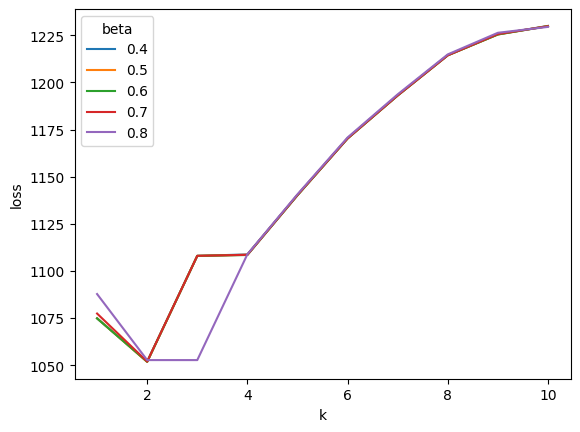

In [16]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [17]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]

In [18]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 2.0
Optimal beta: 0.5


## Fit NMD

In [19]:
# k_opt = 2

##### Nuclear norm

In [20]:
k_opt = int(k_opt)

In [22]:
m, n = data_counts.X.shape
X_nmd = ut.convert_to_dense_counts(data_counts, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X=X_nmd, m=m, n=n, r=int(k_opt))
Theta0 = W0 @ H0

In [23]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(
    X_nmd, r=k_opt, W0=W0, H0=H0, beta1=beta_opt, tol_over_10iters=1e-4
)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 53.767592] - 0.680746 secs
[1 : 53.230347] - 0.685443 secs
[2 : 52.358348] - 0.686659 secs
[3 : 51.423031] - 0.679886 secs
[4 : 50.976018] - 0.680027 secs
[5 : 50.904700] - 0.678049 secs
[6 : 50.865830] - 0.687499 secs
[7 : 50.853370] - 0.681738 secs
[8 : 50.846825] - 0.684003 secs
[9 : 50.842545] - 0.674247 secs
[10 : 50.839232] - 0.687823 secs
[11 : 50.836718] - 0.679917 secs
[12 : 50.834678] - 0.684389 secs
[13 : 50.833110] - 0.663450 secs
[14 : 50.831813] - 0.677023 secs
[15 : 50.830733] - 0.661011 secs
[16 : 50.829821] - 0.649345 secs
[17 : 50.829049] - 0.651865 secs
[18 : 50.828381] - 0.661862 secs
[19 : 50.827811] - 0.668863 secs
[20 : 50.827323] - 0.655441 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 50.82690857935434%, after 22 iterations.
Initialization time: 0.475904 secs
Mean time per iteration: 0.665885 secs
Total time: 15.125366 secs



In [24]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

In [25]:
def plot_embedding_grid(embeddings, hue, size=3, legend_title="Cluster"):
    """
    Plots a grid of scatterplots for all pairwise combinations of embeddings.

    :param embeddings: NumPy array of shape (n_samples, n_features)
    :param hue: Series or list of hue values for coloring points based on clustering
    :param title_prefix: Optional prefix for the plot titles
    """
    # Convert embeddings to a DataFrame
    df_embeddings = pd.DataFrame(embeddings)

    # Add the hue (clustering results) to the DataFrame
    if hue is not None:
        df_embeddings[legend_title] = list(hue)

        # Create pairplot
        g = sns.pairplot(
            df_embeddings, hue=legend_title, size=size, plot_kws={"alpha": 0.3}
        )
    else:
        g = sns.pairplot(df_embeddings, size=size, plot_kws={"alpha": 0.3})

    return g

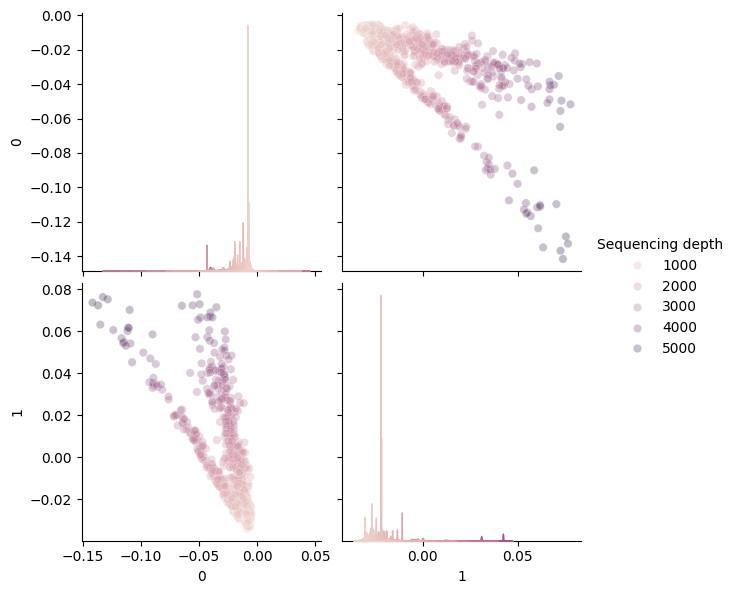

In [26]:
plot_embedding_grid(
    W0, hue=data_counts.obs["total_counts"], size=3, legend_title="Sequencing depth"
)

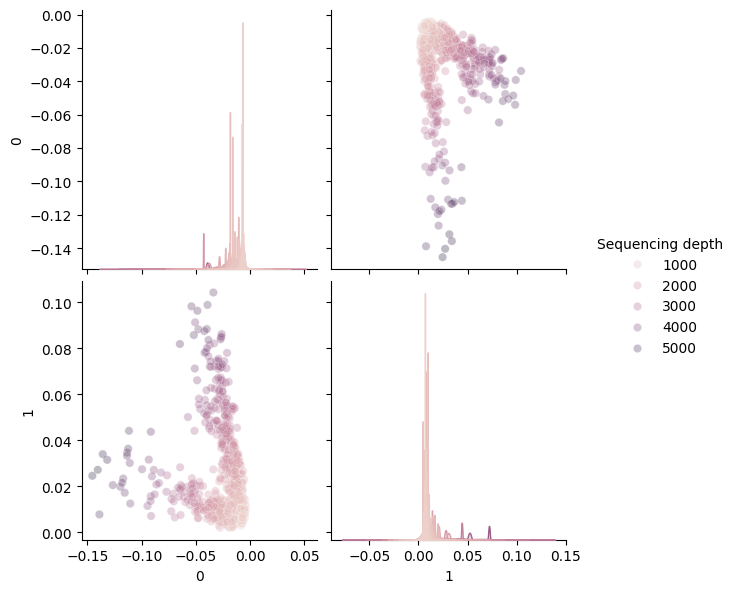

In [27]:
plot_embedding_grid(
    W_3b, hue=data_counts.obs["total_counts"], size=3, legend_title="Sequencing depth"
)

##### Row-wise mean init

# def factor_theta(theta, rank):
    ua, sa, va = np.linalg.svd(theta, full_matrices=False)
    sa = np.diag(sa)[:rank, :rank]
    W0 = ua[:, :rank]
    H0 = sa @ va[:rank, :]
    return W0, H0

In [60]:
shape = X_nmd.shape
row_means = np.mean(X_nmd, axis=1)
Theta0_rowmeans = np.repeat(row_means, shape[1]).reshape(shape)

In [61]:
W0_rm, H0_rm = factor_theta(Theta0_rowmeans, rank=k_opt)

In [62]:
Theta_3b_rm, W_3b_rm, H_3b_rm, loss_3b_rm, iters_3b_rm, times_3b_rm = nmd.nmd_3b(
    X_nmd, r=k_opt, W0=W0_rm, H0=H0_rm, beta1=beta_opt, tol_over_10iters=1e-4
)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 61.782468] - 0.644161 secs
[1 : 50.974869] - 0.648588 secs
[2 : 50.851656] - 0.647537 secs
[3 : 50.834637] - 0.641036 secs
[4 : 50.827429] - 0.638259 secs
[5 : 50.825075] - 0.640794 secs
[6 : 50.824129] - 0.645797 secs
[7 : 50.823580] - 0.635937 secs
[8 : 50.823200] - 0.634597 secs
[9 : 50.822985] - 0.638098 secs
[10 : 50.822853] - 0.647227 secs
[11 : 50.822751] - 0.632185 secs
[12 : 50.822670] - 0.643531 secs
[13 : 50.822605] - 0.645199 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 50.82255671722825%, after 15 iterations.
Initialization time: 0.435880 secs
Mean time per iteration: 0.630817 secs
Total time: 9.898133 secs



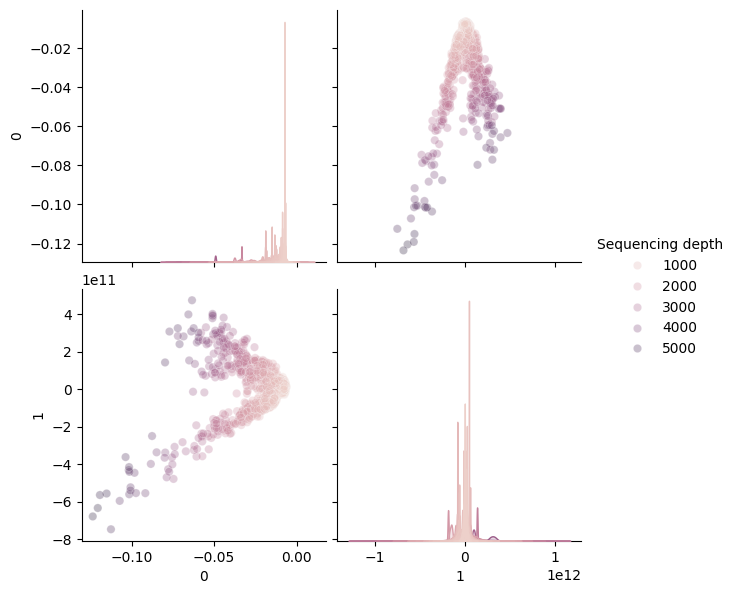

In [63]:
plot_embedding_grid(
    W_3b_rm,
    hue=data_counts.obs["total_counts"],
    size=3,
    legend_title="Sequencing depth",
)

In [33]:
data_counts.obsm["X_3b"] = W_3b.copy()

In [35]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]
(
    scdeed_result,
    rel_scores,
    null_rel_scores,
    reliabilities,
    n_neighbors_opt,
    min_dist_opt,
) = scd.scdeed_parameter_selection(
    data_counts,
    n_neighborss,
    min_dists,
    n_pcs=k_opt,
    rng_seed=5678,
    layer=data_layer,
    dim_red_method="3B-NMD",
    dim_red_params={"beta1": beta_opt, "tol_over_10iters": tol_over_10iters},
    embedding_method="UMAP",
    similarity_percent=0.5,
    save_path="S2_filtered_scdeed_nmd",
)

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 30
Optimal min_dist: 0.1


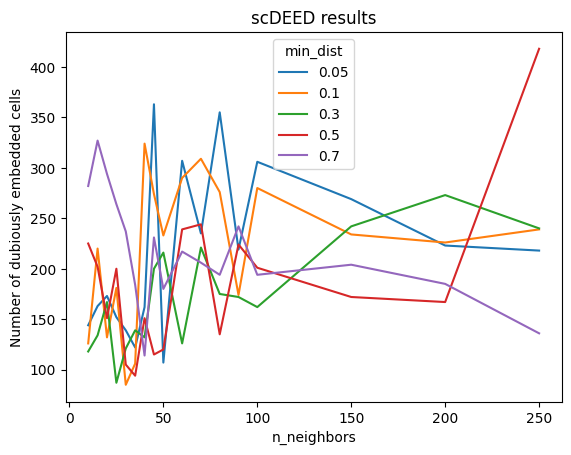

In [36]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(
    data=scdeed_result,
    x="n_neighbors",
    y="num_dubious",
    hue="min_dist",
    palette="tab10",
)
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [37]:
sc.pp.neighbors(data_counts, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_counts, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

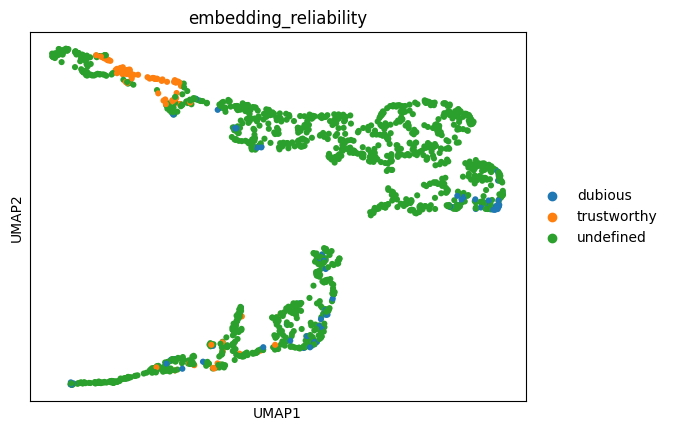

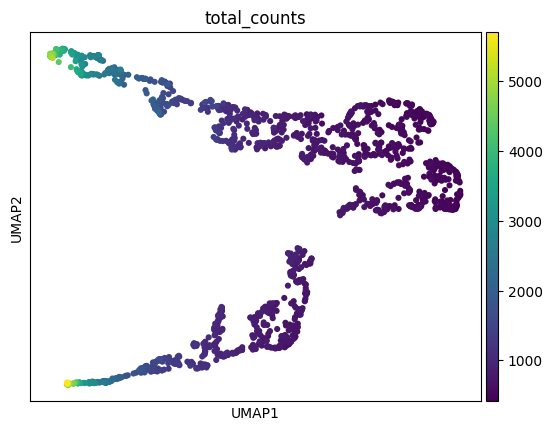

In [38]:
sc.pl.umap(data_counts, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_counts, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [39]:
data_train, data_test = cs.countsplit_adata(
    data_counts,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer=data_layer,
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

In [40]:
X_train = ut.convert_to_dense_counts(data_train, layer=data_layer)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, k_opt)

In [41]:
X_test = ut.convert_to_dense_counts(data_test, layer=data_layer)
m, n = X_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, k_opt)

In [42]:
_, W_train, H_train, _, _, _ = nmd.nmd_3b(
    X_train, r=k_opt, W0=W0_train, H0=H0_train, beta1=beta_opt
)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 69.790900] - 0.644957 secs
[1 : 69.284715] - 0.648792 secs
[2 : 69.095481] - 0.650762 secs
[3 : 69.023640] - 0.645551 secs
[4 : 68.997090] - 0.666007 secs
[5 : 68.969617] - 0.649815 secs
[6 : 68.937942] - 0.676841 secs
[7 : 68.897088] - 0.654768 secs
[8 : 68.841281] - 0.654863 secs
[9 : 68.764436] - 0.655463 secs
[10 : 68.660984] - 0.659364 secs
[11 : 68.525079] - 0.649719 secs
[12 : 68.353106] - 0.653956 secs
[13 : 68.148723] - 0.646750 secs
[14 : 67.928303] - 0.650808 secs
[15 : 67.720310] - 0.652168 secs
[16 : 67.553548] - 0.646886 secs
[17 : 67.439981] - 0.654639 secs
[18 : 67.367604] - 0.657913 secs
[19 : 67.316238] - 0.641836 secs
[20 : 67.275002] - 0.646941 secs
[21 : 67.241443] - 0.658676 secs
[22 : 67.214997] - 0.655319 secs
[23 : 67.194696] - 0.638992 secs
[24 : 67.179313] - 0.654739 secs
[25 : 67.167782] - 0.650393 secs
[26 : 67.159162] - 0.651603 secs
[27 : 67.152631] - 0.641720 

In [43]:
_, W_test, H_test, _, _, _ = nmd.nmd_3b(
    X_test, r=k_opt, W0=W0_test, H0=H0_test, beta1=beta_opt
)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 70.134469] - 0.639722 secs
[1 : 69.622124] - 0.642688 secs
[2 : 69.433244] - 0.652527 secs
[3 : 69.366698] - 0.654535 secs
[4 : 69.339677] - 0.639271 secs
[5 : 69.315882] - 0.649221 secs
[6 : 69.288474] - 0.661409 secs
[7 : 69.252410] - 0.654004 secs
[8 : 69.201845] - 0.649579 secs
[9 : 69.129115] - 0.658104 secs
[10 : 69.025003] - 0.658614 secs
[11 : 68.877505] - 0.657200 secs
[12 : 68.673522] - 0.651209 secs
[13 : 68.407111] - 0.658341 secs
[14 : 68.094290] - 0.658633 secs
[15 : 67.787586] - 0.658678 secs
[16 : 67.560369] - 0.646425 secs
[17 : 67.439862] - 0.671188 secs
[18 : 67.385646] - 0.663034 secs
[19 : 67.353826] - 0.655065 secs
[20 : 67.332343] - 0.648875 secs
[21 : 67.318926] - 0.671647 secs
[22 : 67.310522] - 0.662670 secs
[23 : 67.305147] - 0.652589 secs
[24 : 67.301497] - 0.642388 secs
[25 : 67.298837] - 0.648712 secs
[26 : 67.296762] - 0.650515 secs
[27 : 67.295018] - 0.649516 

In [44]:
data_train.obsm["X_3b"] = W_train
data_test.obsm["X_3b"] = W_test

In [45]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")

In [46]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

In [47]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(
    data_train, data_test, resolutions
)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.477 - Test: 0.425 - Random: 0.25
resolution: 0.05 - clusters: 3 - Train: 0.468 - Test: 0.387 - Random: 0.154
resolution: 0.07 - clusters: 3 - Train: 0.458 - Test: 0.377 - Random: 0.142
resolution: 0.09 - clusters: 4 - Train: 0.455 - Test: 0.362 - Random: 0.12
resolution: 0.11 - clusters: 4 - Train: 0.449 - Test: 0.356 - Random: 0.114
resolution: 0.13 - clusters: 5 - Train: 0.444 - Test: 0.333 - Random: 0.086
resolution: 0.15 - clusters: 6 - Train: 0.441 - Test: 0.268 - Random: 0.059
resolution: 0.17 - clusters: 6 - Train: 0.436 - Test: 0.272 - Random: 0.057
resolution: 0.19 - clusters: 7 - Train: 0.432 - Test: 0.259 - Random: 0.05
resolution: 0.21 - clusters: 7 - Train: 0.429 - Test: 0.252 - Random: 0.046
resolution: 0.23 - clusters: 7 - Train: 0.427 - Test: 0.249 - Random: 0.043
resolution: 0.25 - clusters: 7 - Train: 0.423 - Test: 0.231 - Random: 0.039
resolution: 0.27 -

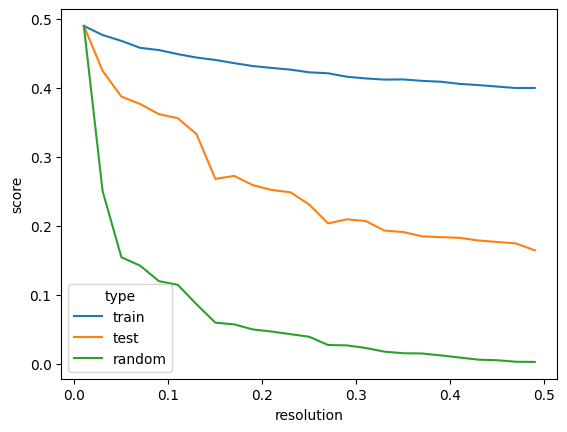

In [48]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

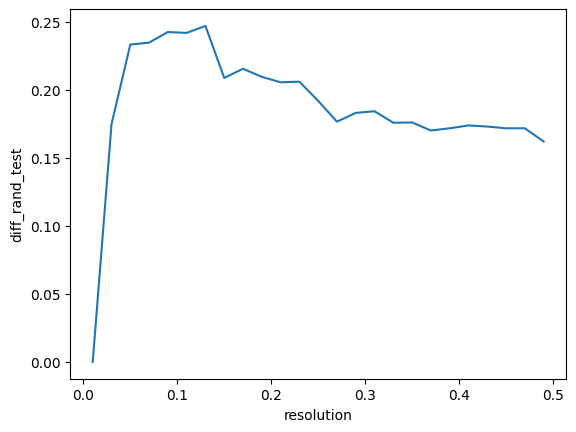

In [49]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [50]:
sc.tl.leiden(data_counts, resolution=res_opt, key_added="leiden_opt")

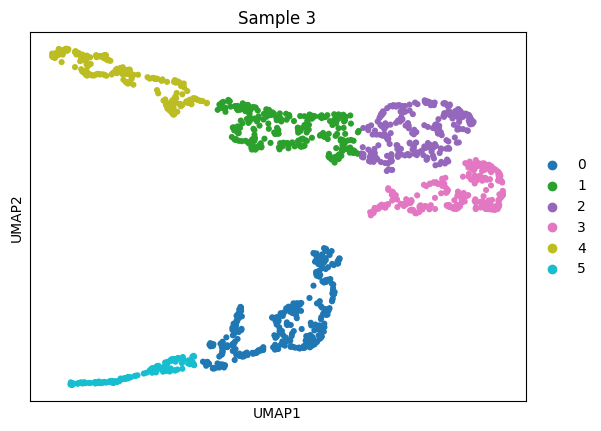

In [51]:
sc.pl.umap(data_counts, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

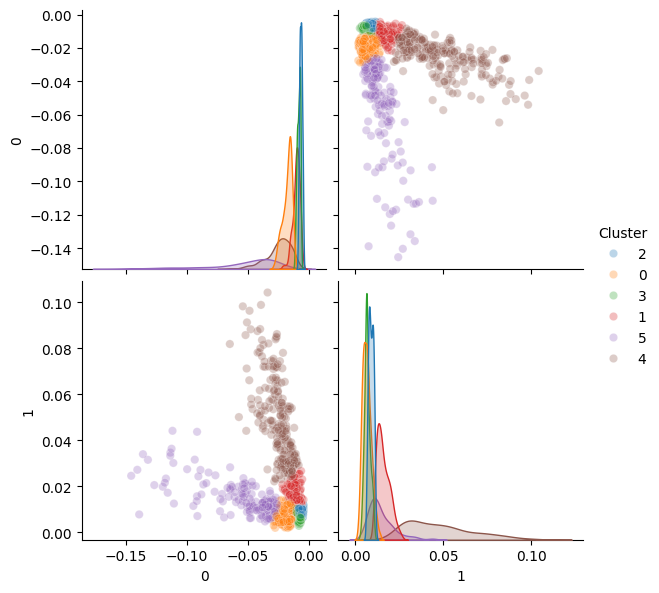

In [52]:
nmd_plot.plot_embedding_grid(
    data_counts.obsm["X_3b"], hue=data_counts.obs["leiden_opt"], size=3
)

In [53]:
pd.crosstab(
    data_all_pca.obs["leiden_opt"],
    data_counts.obs["leiden_opt"],
    rownames=["PCA"],
    colnames=["NMD"],
)

NMD,0,1,2,3,4,5
PCA,,,,,,
0,36,89,190,200,0,2
1,309,0,3,16,1,153
2,0,172,59,5,233,2
3,16,15,18,18,1,6


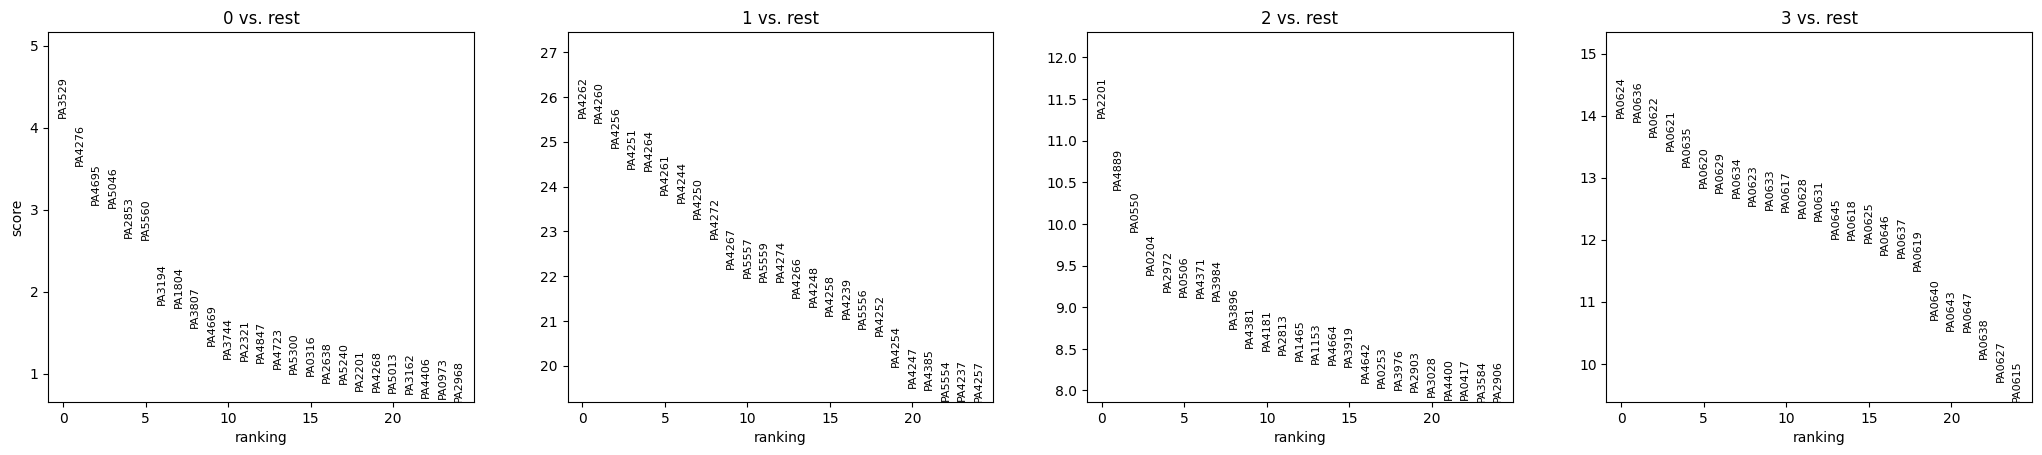

In [54]:
sc.tl.rank_genes_groups(data_all_pca, "leiden_opt", method="wilcoxon")
sc.pl.rank_genes_groups(data_all_pca, n_genes=25, sharey=False)

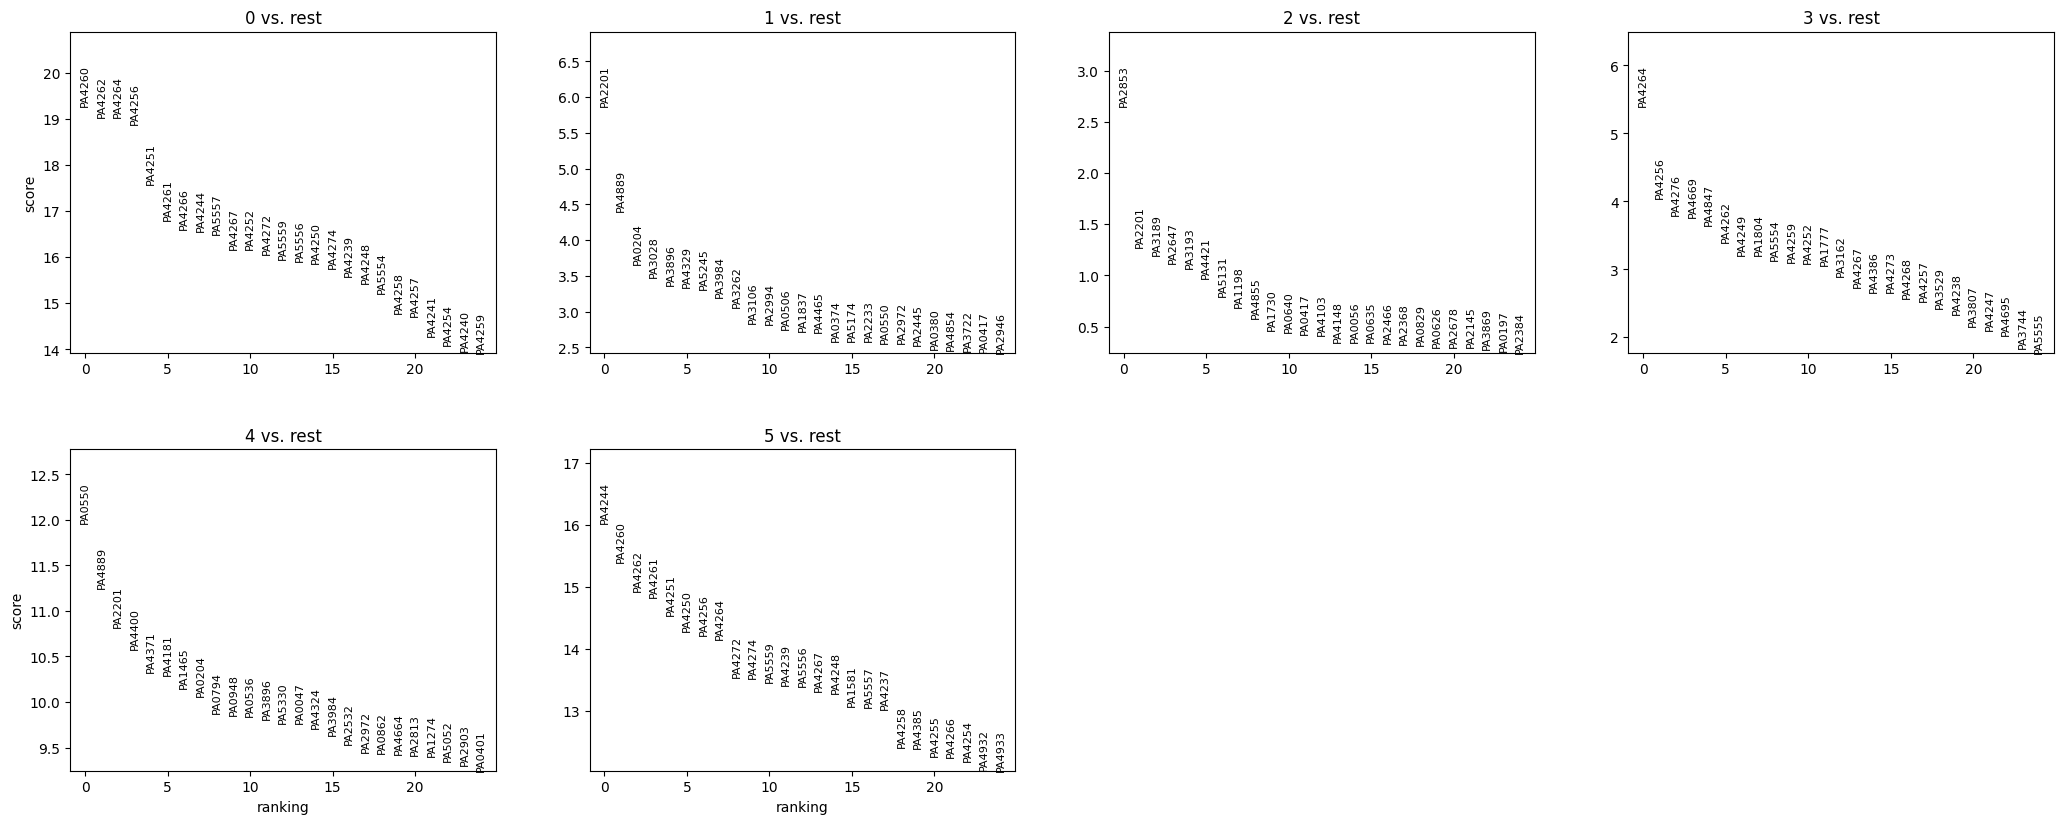

In [55]:
sc.tl.rank_genes_groups(data_counts, "leiden_opt", method="wilcoxon")
sc.pl.rank_genes_groups(data_counts, n_genes=25, sharey=False)

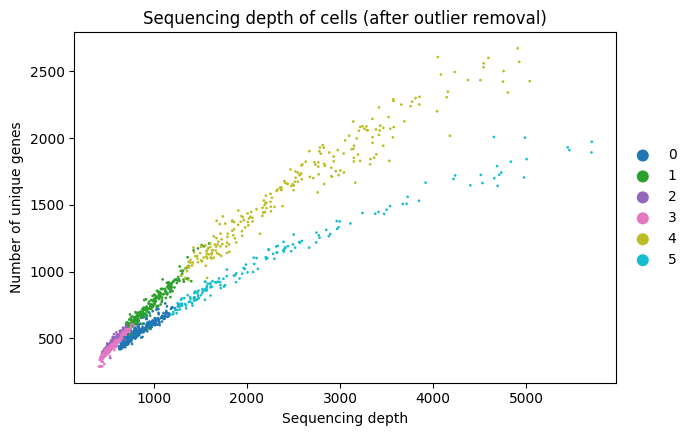

In [56]:
sc.pl.scatter(
    data_counts,
    x="total_counts",
    y="n_genes_by_counts",
    show=False,
    size=15,
    color="leiden_opt",
)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [57]:
top_genes_3 = [x[2] for x in data_counts.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA2853', 'PA2201', 'PA3189', 'PA2647', 'PA3193', 'PA4421', 'PA5131', 'PA1198', 'PA4855', 'PA1730', 'PA0640', 'PA0417', 'PA4103', 'PA4148', 'PA0056', 'PA0635', 'PA2466', 'PA2368', 'PA0829', 'PA0626', 'PA2678', 'PA2145', 'PA3869', 'PA0197', 'PA2384']


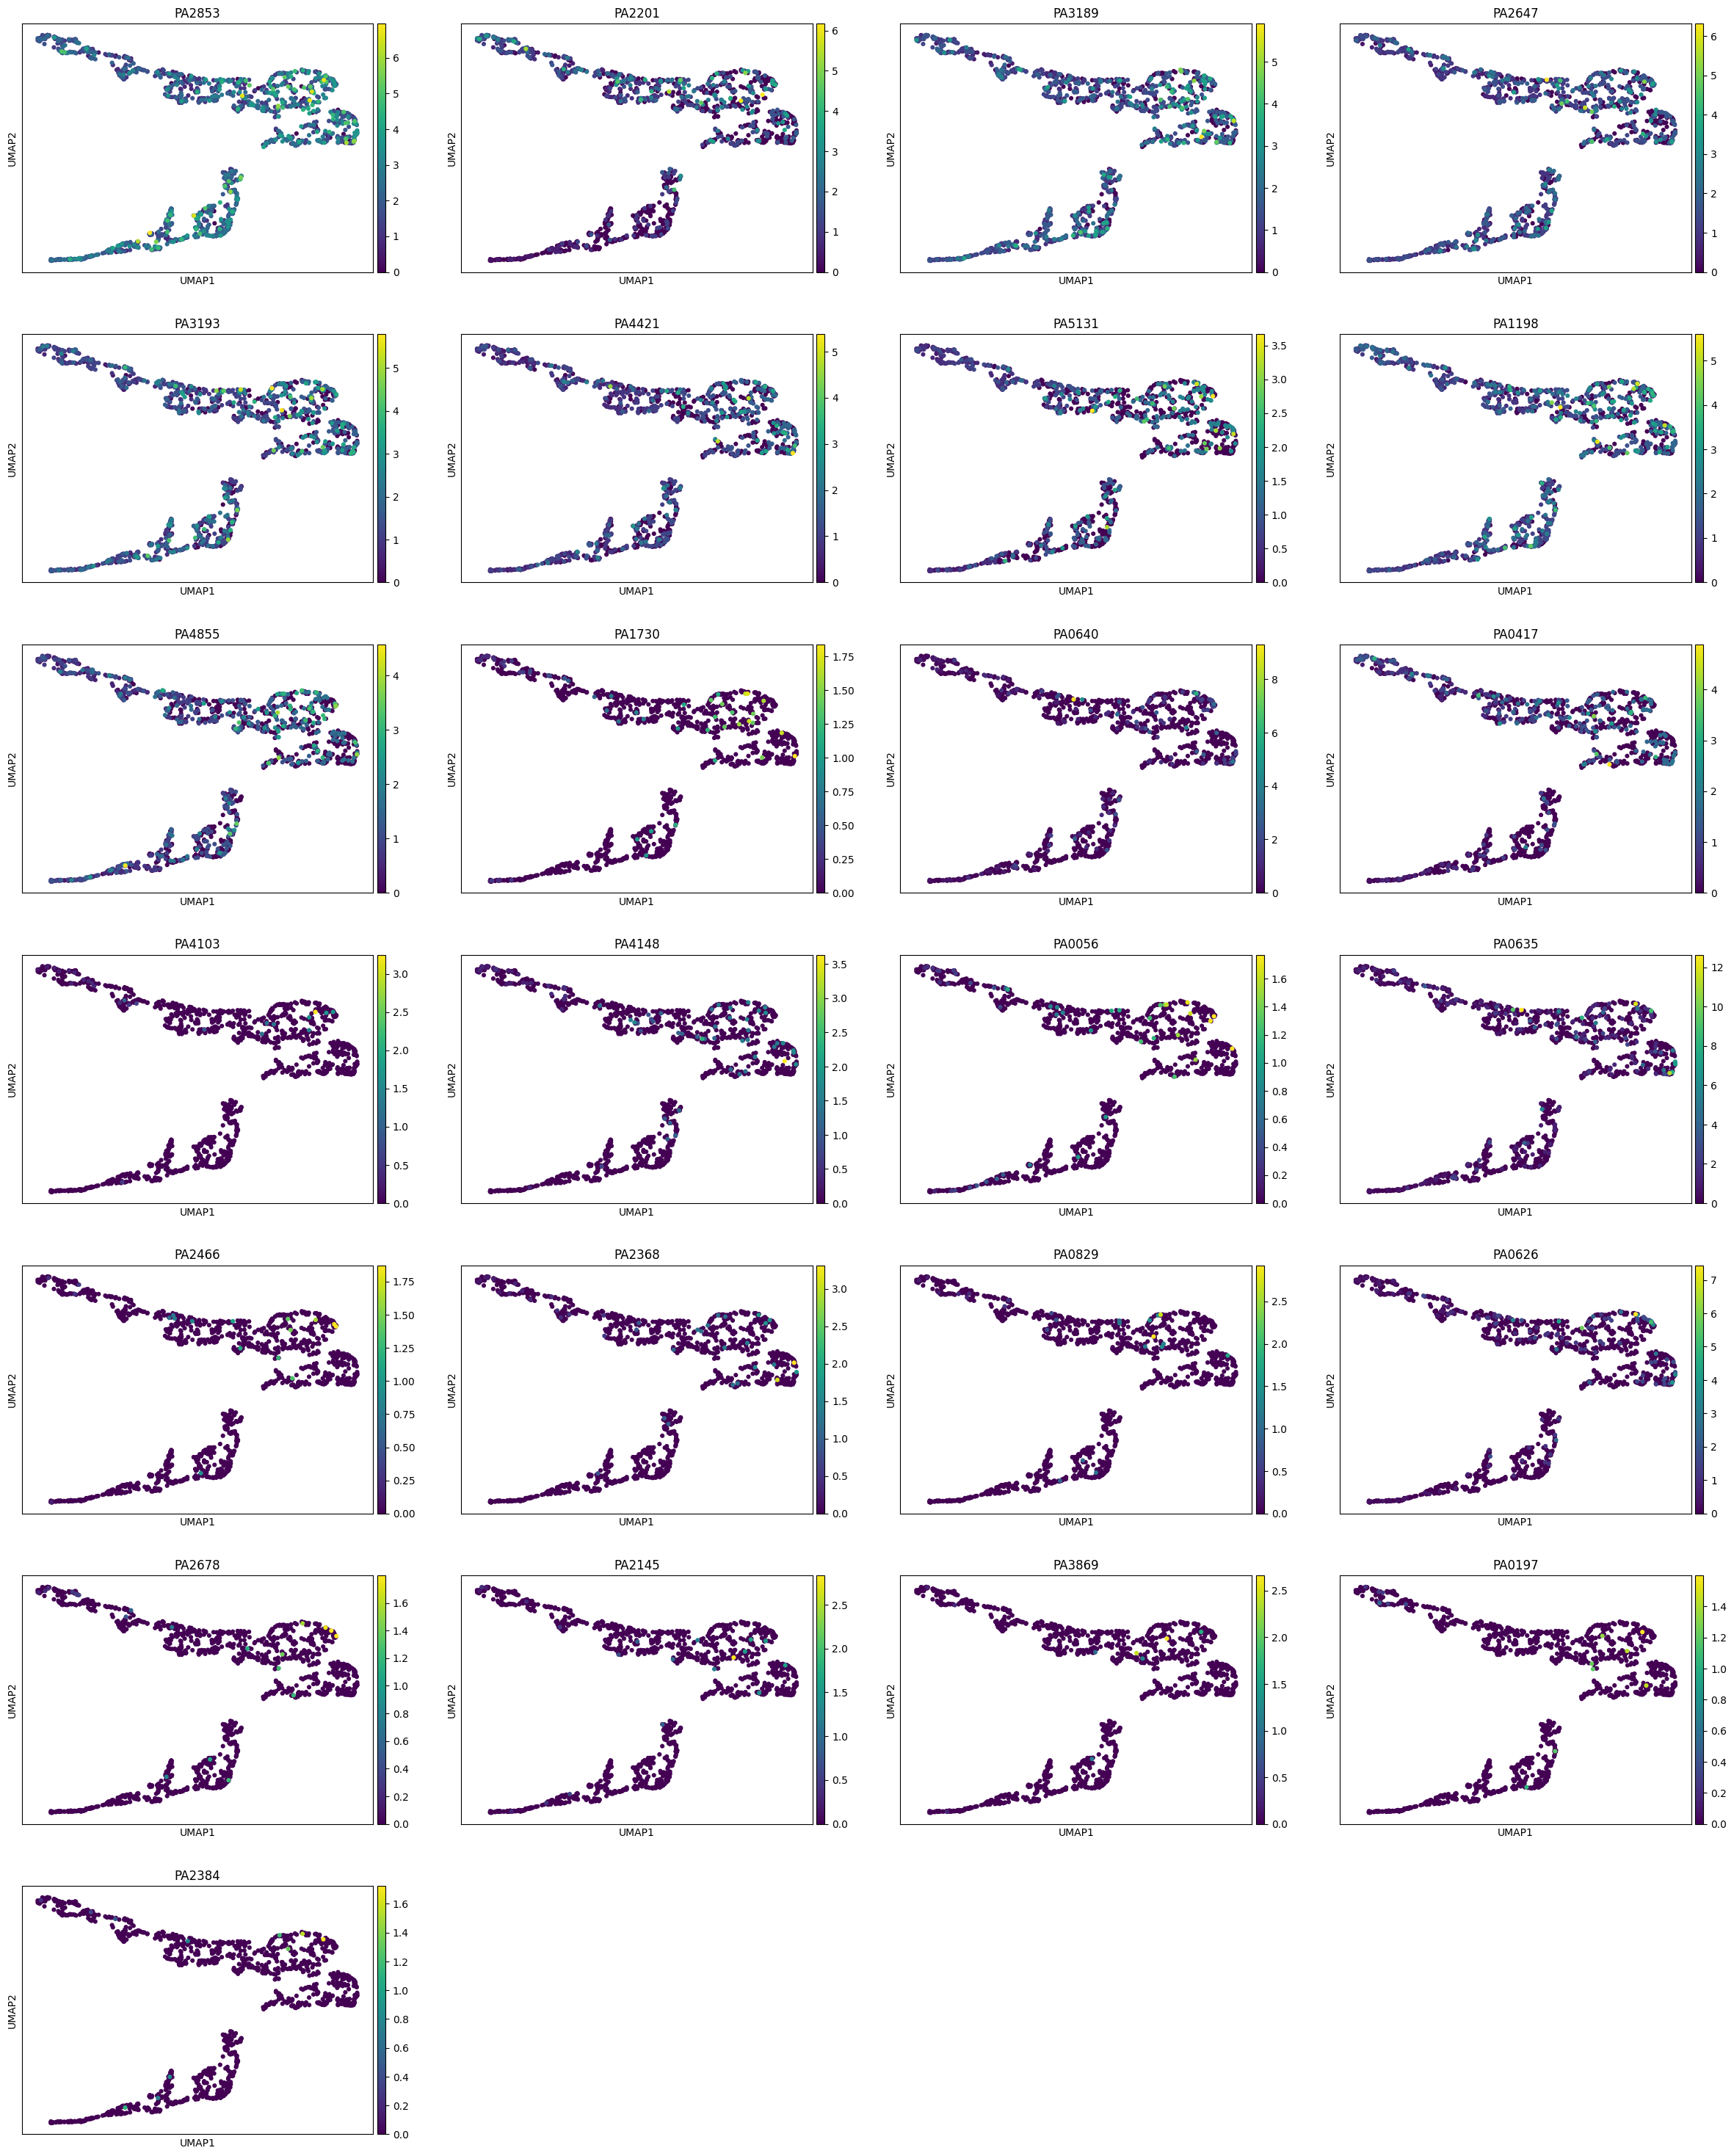

In [58]:
sc.pl.umap(data_counts, color=top_genes_3[:25], palette="tab20", cmap="viridis")

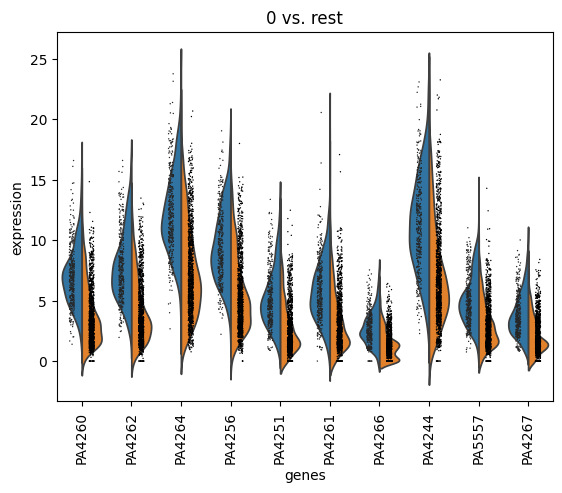

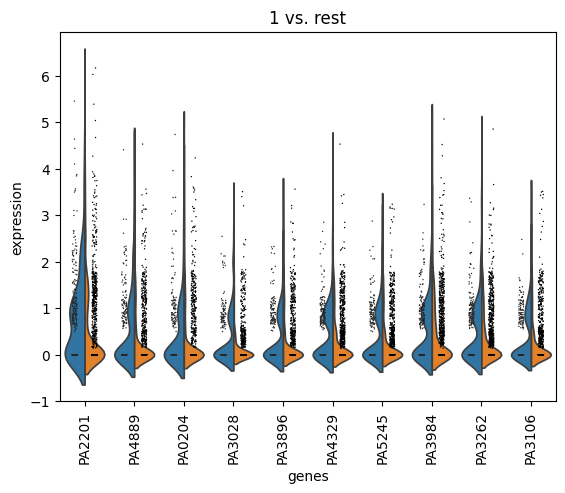

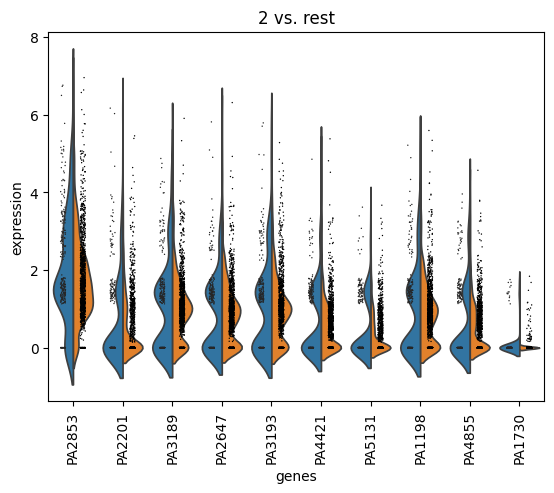

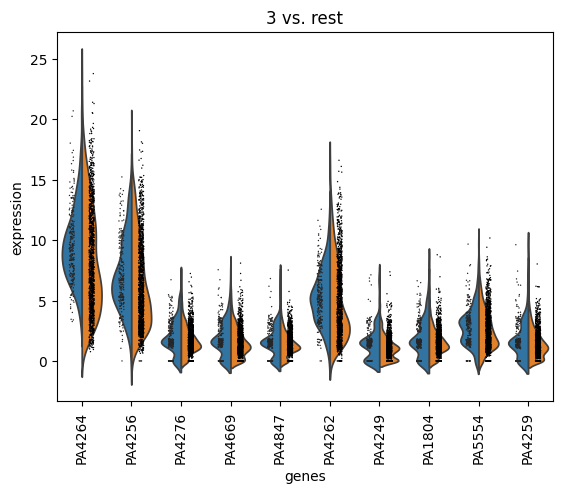

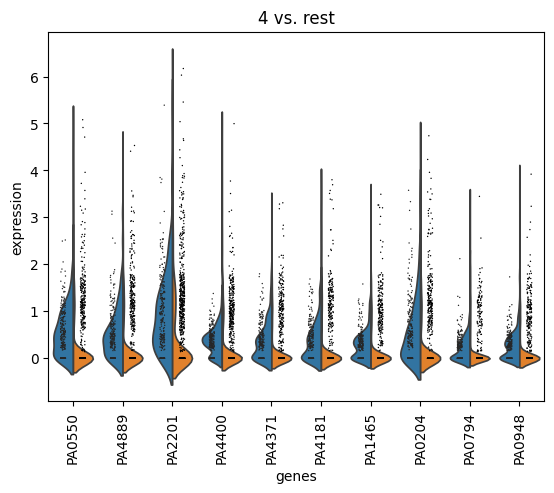

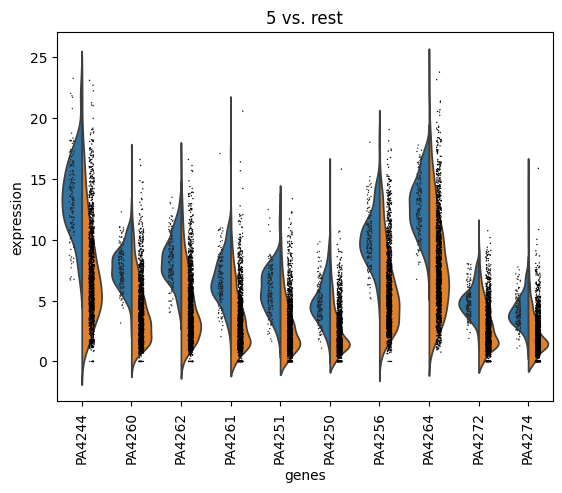

In [59]:
nclust = len(np.unique(data_counts.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_counts, groups=str(i), n_genes=10)